In [ ]:
#Feature engeneering 


#Feature celection 
#https://www.youtube.com/watch?v=KTzXVnRlnw4
#https://www.youtube.com/watch?v=TsqTuwTKFSs

#https://arxiv.org/pdf/1606.07792.pdf

#https://www.youtube.com/watch?v=d12ra3b_M-0

#https://www.youtube.com/watch?v=9Vk1rXLhG48


#https://github.com/random-forests/tensorflow-workshop/blob/master/examples/07_structured_data.ipynb?utm_campaign=ai_series_tensorflowcode_103017&utm_source=gdev&utm_medium=yt-desc

#Keggal Titanik
#https://github.com/kaggledecal/sp17/blob/master/day05/Cleaning%20and%20RegEx.ipynb

#Text Analytics
#https://www.youtube.com/watch?v=hXNbFNCgPfY


# wolpert stack generalisation

#Network prediction in Python
#https://www.youtube.com/watch?v=nN84qeE0jtM
#https://www.youtube.com/watch?v=QYhgLVt56z8
#https://github.com/muhanzhang/LinkPrediction/blob/master/WLNM.m


# for link prediction from links' enclosing subgraphs
#https://github.com/muhanzhang/LinkPrediction/blob/master/README.md
#https://github.com/muhanzhang/pytorch_DGCNN/blob/master/README.md

In [36]:
#import pandas as pd
import os
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix
from sklearn import preprocessing


import tensorflow as tf

from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from pandas.plotting import scatter_matrix
import pandas as pd
from scipy.stats import mode, pearsonr, f_oneway
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
import h5py
from sklearn import metrics

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns



In [2]:
#Useful Functions

#Encode a numeric column as z_Score
def encode_num_zscore(df,name, mean=None, sd=None):
    if mean is None:
        mean_name=df[name].mean()
        
    if sd is None:
        sd=df[name].std()
        
    df[name]=(df[name]-mean_name)/sd  

#Encode a numeric column as min-max
def encode_num_MM(df, name):
    df[name]=(df[name] - df[name].min())/(df[name].max()-df[name].min())
    
#Encode a numeric value as simple scalin
def encode_num_SS(df,name):
    df[name]=df[name]/df[name].max()
    
#Encode text values to dummy variables ([1,0,0],[0,1,0],[0,0,1])        
def encode_text_dummy(df,name):
    dummies=pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name,x)
        df[dummy_name]=dummies[x]
    df.drop(name, axis=1,inplace=True)
    
# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_

#Binning the data using equal Width algorithm
def binning_data_EquWidth(df, name, new_name, number_of_bins, group_name = None):
    binband = int((max(df[name]) - min(df[name]))/(number_of_bins + 1))
    print(binband)
    binrange = range(int(min(df[name])), int(max(df[name])),binband)
    group_name_create=[]
    if group_name == None:
        for i in range(number_of_bins+1):
            group_name_create.append(i)
    else:
        group_name_create = group_name
    df[new_name] =pd.cut(df[name], binrange, labels=group_name_create)
    return df
    
    
#Convert a Pandas dataframe into the x,y inputs the Tensor Flow needs
def tensor_flow_xy(df, target):
    result=[]
    for x in df.columns:
        if x!=target:
            result.append(x)
    #find out the type of the target column
    target_type =df[target].dtypes
    target_type=target_type[0] if hasattr(target_type, '__iter__') else target_type
    #Encode to int for classification, float otherwise
    if target_type in (np.int64, np.int32):
        #Classification
        dummies=pd.get_dummies(df[target])
        return df.as_matrix(result).astype(np.float32), dummies.as_matrix().astype(np.float32)
    else:
        #Regression
        return df.as_matrix(result).astype(np.float32), df.as_matrix([target]).astype(np.float32)
#Convert all missing text values to mode
def missing_text_mode(df,name,default_value=None):
    mod=df[name].mode()[0]
    df[name]=df[name].fillna(mod)
    
#Convert all missing values to median
def missing_median(df,name,default_value=None):
    med=df[name].median()
    df[name]=df[name].fillna(med)

#Convert all missing values to default_value
def missing_default(df,name,default_value):
    df[name]=df[name].fillna(default_value)
    
# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y):
    fpr, tpr, _ = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()
    
#Finding outliers with Tukey method
def find_outlier_tukey(df, name,fl, ceil):
    q1 = np.percentile(df[name],25)
    q3 = np.percentile(df[name],75)
    iqr = q3 -q1
    floor = q1 - fl*iqr
    ceiling = q3 + ceil*iqr

    #https://www.youtube.com/watch?v=2Qrost474lQ
    #res = df[name].Values.quantile(floor, ceiling)
    #true_index = (res.loc[floor]<df[name].Values.values)&(res.loc[ceiling]>df[name].Values.value)
    #false_index = ~true_index
    
    outlier_indecies = list(df[name].index[(df[name]<floor) | (df[name]>ceiling)])
    outlier_values = list(df[name][outlier_indecies])
    return outlier_indecies, outlier_values    #, true_index, false_index

#Changing outlier with the mode value
def outlier_to_mode(df, name, column_number,column_mode, column_outlier):
    itergl = df.iloc[:,column_number].values 
    for x in itergl:
        if x >column_outlier:
            df.replace({
            name: x
            }, column_mode, inplace = True)
            
# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)

In [3]:
# Import training data as train and test DataFrames

train = pd.read_csv("train_ajEneEa.csv")
test = pd.read_csv("test_v2akXPA.csv")
print('Train: ', train.shape)
print('Test: ', test.shape)
print(train.dtypes)
print('')
print('Missing Data in the Train Sample: \n', train.isnull().sum())
print('')
print('Missing Data in the Test Sample: \n',test.isnull().sum())

#print('Train Sample: \n',train.describe())
#print('Test Sample: \n',test.describe())

print('Train:',train['bmi'].mean())
print('Test',test['bmi'].mean())
print('Train mode',train['smoking_status'].mode())
print('Test mode',test['smoking_status'].mode())
train.describe()

Train:  (43400, 12)
Test:  (18601, 11)
id                     int64
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

Missing Data in the Train Sample: 
 id                       0
gender                   0
age                      0
hypertension             0
heart_disease            0
ever_married             0
work_type                0
Residence_type           0
avg_glucose_level        0
bmi                   1462
smoking_status       13292
stroke                   0
dtype: int64

Missing Data in the Test Sample: 
 id                      0
gender                  0
age                     0
hypertension            0
heart_disease           0
ever_married            0
work_type               0
Residen

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,43400.000000,43400.000000,43400.000000,43400.000000,43400.000000,41938.000000,43400.000000
mean,36326.142350,42.217894,0.093571,0.047512,104.482750,28.605038,0.018041
std,21072.134879,22.519649,0.291235,0.212733,43.111751,7.770020,0.133103
min,1.000000,0.080000,0.000000,0.000000,55.000000,10.100000,0.000000
25%,18038.500000,24.000000,0.000000,0.000000,77.540000,23.200000,0.000000
50%,36351.500000,44.000000,0.000000,0.000000,91.580000,27.700000,0.000000
75%,54514.250000,60.000000,0.000000,0.000000,112.070000,32.900000,0.000000
max,72943.000000,82.000000,1.000000,1.000000,291.050000,97.600000,1.000000


In [4]:
#Finding the subgroups in the column
print(train.head(5))
tr_res_group=train.groupby('Residence_type')
tr_res_group.describe()

      id  gender   age  hypertension  heart_disease ever_married  \
0  30669    Male   3.0             0              0           No   
1  30468    Male  58.0             1              0          Yes   
2  16523  Female   8.0             0              0           No   
3  56543  Female  70.0             0              0          Yes   
4  46136    Male  14.0             0              0           No   

      work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0      children          Rural              95.12  18.0              NaN   
1       Private          Urban              87.96  39.2     never smoked   
2       Private          Urban             110.89  17.6              NaN   
3       Private          Rural              69.04  35.9  formerly smoked   
4  Never_worked          Rural             161.28  19.1              NaN   

   stroke  
0       0  
1       0  
2       0  
3       0  
4       0  


age                                                      \
                  count       mean        std   min   25%   50%   75%   max   
Residence_type                                                                
Rural           21644.0  42.188573  22.508136  0.08  24.0  44.0  60.0  82.0   
Urban           21756.0  42.247064  22.531576  0.08  24.0  44.0  60.0  82.0   

               avg_glucose_level             ...         id            stroke  \
                           count        mean ...        75%      max    count   
Residence_type                               ...                                
Rural                    21644.0  104.482166 ...   54416.75  72938.0  21644.0   
Urban                    21756.0  104.483331 ...   54614.75  72943.0  21756.0   

                                                             
                    mean       std  min  25%  50%  75%  max  
Residence_type                                               
Rural           0.017742  0.132014  0.0  0.0  0.0  0.0  1.0  
Urban           0.018340  0.134180  0.0  0.0  0.0  0.0  1.0  

[2 rows x 56 columns]

In [4]:
df_tr=train
df_ts=test

#Encoding the object to a value: 1 or 0
df_tr['Residence_type'] = [1 if x == 'Urban' else 0 for x in df_tr['Residence_type']]
df_ts['Residence_type'] = [1 if x == 'Urban' else 0 for x in df_ts['Residence_type']]

#Missing data treatment

#Train Sample
missing_text_mode(df_tr,'smoking_status',default_value=None)
bmi_tr = df_tr['bmi'].mean()
missing_default(df_tr,'bmi',bmi_tr)

#Test Sample
missing_text_mode(df_ts,'smoking_status',default_value=None)
bmi_ts = df_ts['bmi'].mean()
missing_default(df_ts,'bmi',bmi_ts)

print(df_tr.isnull().sum())

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64


In [5]:
#Making variables redundant
df_tr.drop('id', axis =1, inplace = True)
df_ts.drop('id', axis =1, inplace = True)
print(df_tr.head(5))
print(df_ts.head(5))

   gender   age  hypertension  heart_disease ever_married     work_type  \
0    Male   3.0             0              0           No      children   
1    Male  58.0             1              0          Yes       Private   
2  Female   8.0             0              0           No       Private   
3  Female  70.0             0              0          Yes       Private   
4    Male  14.0             0              0           No  Never_worked   

   Residence_type  avg_glucose_level   bmi   smoking_status  stroke  
0               0              95.12  18.0     never smoked       0  
1               1              87.96  39.2     never smoked       0  
2               1             110.89  17.6     never smoked       0  
3               0              69.04  35.9  formerly smoked       0  
4               0             161.28  19.1     never smoked       0  
   gender   age  hypertension  heart_disease ever_married      work_type  \
0    Male  80.0             0              0         

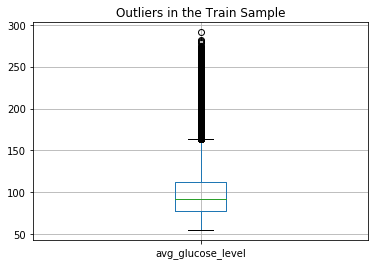

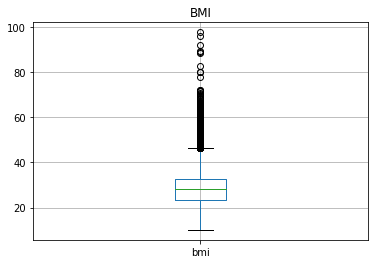

<Figure size 432x288 with 0 Axes>

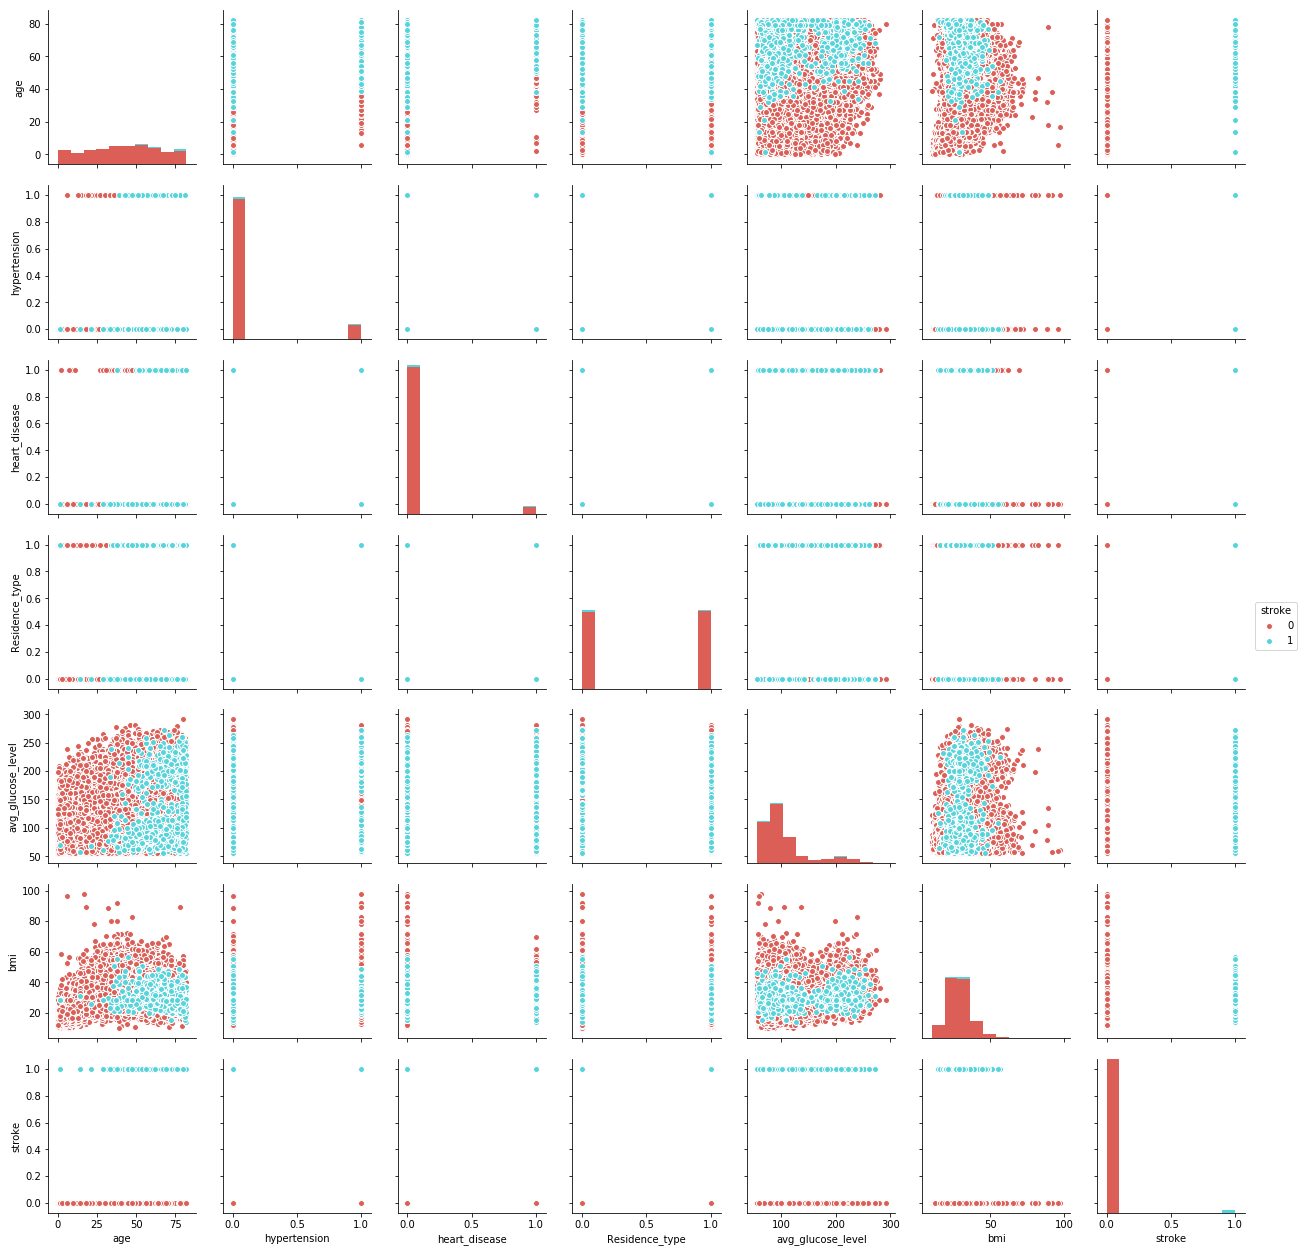

In [7]:
#Graphycal representation of Outliers

#https://www.youtube.com/watch?v=4GJ7mQUWLQo


#plt.subplot(222)
df_sample=df_tr.iloc[:,7:8]
df_sample.boxplot(return_type ='dict')
#df_tr.boxplot(return_type ='dict')
plt.plot()
plt.title('Outliers in the Train Sample')


plt.figure()
df_sample1=df_tr.iloc[:,8:9]
df_sample1.boxplot(return_type='dict')
plt.plot()
plt.grid(True)
plt.yticks()
plt.title('BMI')
#plt.subplot(223)
#sns.boxplot(x='age', y='stroke', data=df_tr, palette = 'hls')
#plt.title('Age vs Stroke Boxplot')
#plt.show()
plt.figure()
sns.pairplot(df_tr, hue = 'stroke', palette ='hls')
plt.show()

In [6]:
#Outliers Treatment

#Tukey Technique

outlier_index, outlier_value= find_outlier_tukey(df_tr,'age',0.55, 0.62)
print(np.sort(outlier_value))

#KDE TEchnique (Kernel Density Estimation)

#from sklearn.preprocessing import scale
#from scipy.stats import gaussian_kde

#kde_scale = scale(list(map(float, df_tr['age'])))
#kde_v=gaussian_kde(kde_scale)
#print(df_tr.shape)
#for i in outlier_index:
#    df_drop=df_tr.drop(axis=0, index=[i], inplace=True)
#print(df_drop)

#Dropping outliesr
agec=df_tr.iloc[:,1:2].values
age_outlier = (agec<=4.0)
df_tr[age_outlier]

[0.08 0.08 0.08 ... 4.   4.   4.  ]


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,3.00,0,0,No,children,0,95.12,18.0,never smoked,0
33,Female,3.00,0,0,No,children,1,73.74,16.0,never smoked,0
42,Male,4.00,0,0,No,children,0,79.17,20.0,never smoked,0
116,Female,0.64,0,0,No,children,1,83.82,24.9,never smoked,0
122,Female,4.00,0,0,No,children,0,93.25,16.6,never smoked,0
129,Female,0.88,0,0,No,children,0,88.11,15.5,never smoked,0
133,Male,4.00,0,0,No,children,0,106.22,16.7,never smoked,0
137,Male,4.00,0,0,No,children,0,110.15,17.1,never smoked,0
170,Female,3.00,0,0,No,children,1,73.20,16.8,never smoked,0
191,Female,2.00,0,0,No,children,0,92.48,18.0,never smoked,0


In [8]:
#Following the diagram, replace the outliers in glucose and bmi with the corresponding mode
#https://www.youtube.com/watch?v=3dt4OGnU5sM

gl_mode = df_tr['avg_glucose_level'].mode()[0]
bmi_mode = df_tr['bmi'].mode()[0]

outlier_to_mode(df_tr, 'avg_glucose_level', 7,gl_mode, 280.0)
outlier_to_mode(df_tr, 'bmi', 8,bmi_mode, 75.5)


In [9]:
print(df_tr.dtypes)
#Dropping outlier
df_tr.drop(outlier_index, inplace = True)

print(df_tr.shape)

gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type         int64
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object
(41038, 11)


In [10]:
df_tr.describe()

,age,hypertension,heart_disease,Residence_type,avg_glucose_level,bmi,stroke
count,41038.000000,41038.000000,41038.000000,41038.000000,41038.000000,41038.000000,41038.000000
mean,44.531507,0.098957,0.050222,0.500560,105.154672,29.170278,0.019056
std,20.925852,0.298608,0.218405,0.500006,43.844139,7.350047,0.136722
min,5.000000,0.000000,0.000000,0.000000,55.010000,10.100000,0.000000
25%,28.000000,0.000000,0.000000,0.000000,77.590000,24.200000,0.000000
50%,46.000000,0.000000,0.000000,1.000000,91.790000,28.600000,0.000000
75%,61.000000,0.000000,0.000000,1.000000,112.640000,33.000000,0.000000
max,82.000000,1.000000,1.000000,1.000000,279.660000,72.200000,1.000000


In [15]:
#Grouping the categories in the column

#https://www.youtube.com/watch?v=V0u6bxQOUJ8
#filterin with "set" function : https://www.youtube.com/watch?v=PaFZXSlBVMQ
#selection with "filter" function: https://www.youtube.com/watch?v=2AFGPdNn4FM

un_cat_count = df_tr['avg_glucose_level'].value_counts().sort_values(ascending = False)
#print(un_cat_count)

index_count=[]
val_count=[]
for val, ind in un_cat_count.iteritems():
    index_count.append(ind)
    val_count.append(val)
ser_val = pd.Series(val_count[:])
ser_val[:5]
index_count[:5]

[22, 18, 18, 17, 17]

AttributeError: module 'matplotlib.pyplot' has no attribute 'tick'

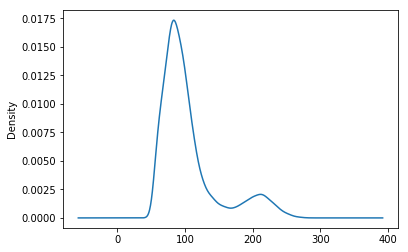

In [21]:
un_cat_count
plt.figure()
df_tr['avg_glucose_level'].plot.kde()

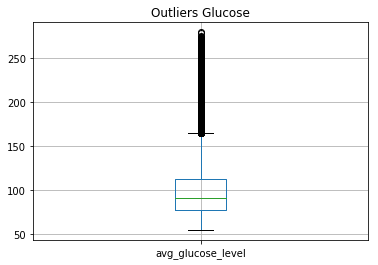

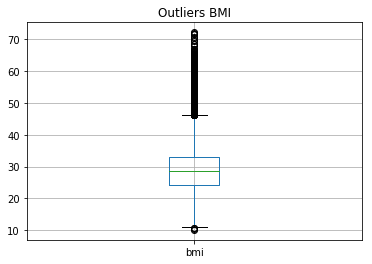

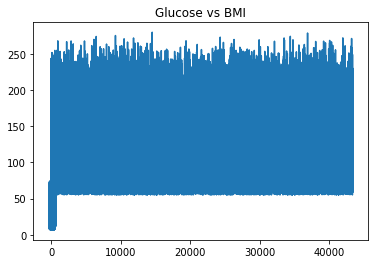

In [15]:
plt.figure()
df_sample=df_tr.iloc[:,7:8]
df_sample.boxplot(return_type ='dict')
#df_tr.boxplot(return_type ='dict')
plt.plot()
plt.title('Outliers Glucose')

plt.figure()
df_sample=df_tr.iloc[:,8:9]
df_sample.boxplot(return_type ='dict')
#df_tr.boxplot(return_type ='dict')
plt.plot()
plt.title('Outliers BMI')

glucc=df_tr.iloc[:,7:8].values
bmic=df_tr.iloc[:,8:9].values

plt.figure()
df_tr['avg_glucose_level'].plot(label = 'Glucose')
plt.scatter(glucc,bmic)
plt.title('Glucose vs BMI')
plt.show()



In [29]:
#Visualising the unique categories in each carachteristic variable
for col_name in df_tr.columns:
    if df_tr[col_name].dtypes =='object':
        unic_cat = len(df_tr[col_name].unique())
        print('The unique categories {}-{}'.format(col_name=col_name, unic_cat = unic_cat ))

In [7]:
#Encoding the carachter values as indecies
caract_val = df_tr.dtypes.loc[df_tr.dtypes == 'object'].index

for i in caract_val:
    encode_text_index(df_tr, i)
    encode_text_index(df_ts, i)
print(df_tr.head(5))    

   gender   age  hypertension  heart_disease  ever_married  work_type  \
0       1   3.0             0              0             0          4   
1       1  58.0             1              0             1          2   
2       0   8.0             0              0             0          2   
3       0  70.0             0              0             1          2   
4       1  14.0             0              0             0          1   

   Residence_type  avg_glucose_level   bmi  smoking_status  stroke  
0               0              95.12  18.0               1       0  
1               1              87.96  39.2               1       0  
2               1             110.89  17.6               1       0  
3               0              69.04  35.9               0       0  
4               0             161.28  19.1               1       0  


In [8]:
#Normalisation
encode_num_SS(df_tr,'bmi')
encode_num_SS(df_tr,'avg_glucose_level')
encode_num_SS(df_tr,'age')

encode_num_SS(df_ts,'bmi')
encode_num_SS(df_ts,'avg_glucose_level')
encode_num_SS(df_ts,'age')

In [13]:
df_tr.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1,1,0.707317,1,0,1,2,1,0.314525,0.542936,1,0
2,0,0.097561,0,0,0,2,1,0.396517,0.243767,1,0
3,0,0.853659,0,0,1,2,0,0.246871,0.497230,0,0
4,1,0.170732,0,0,0,1,0,0.576700,0.264543,1,0
5,0,0.573171,0,0,1,2,1,0.754309,0.693906,1,0


In [14]:
print(df_tr.dtypes)

gender                 int64
age                  float64
hypertension           int64
heart_disease          int64
ever_married           int64
work_type              int64
Residence_type         int64
avg_glucose_level    float64
bmi                  float64
smoking_status         int64
stroke                 int64
dtype: object


In [9]:
x,y = tensor_flow_xy(df_tr,'stroke')

x_tr, x_valid, y_tr, y_valid = train_test_split(
                                                x , y,
                                                test_size = 0.1,
                                                random_state = 45)

x_train, x_test, y_train, y_test = train_test_split(
                                                x_tr , y_tr,
                                                test_size = 0.3,
                                                random_state = 45)

In [30]:
#The Model
from keras import metrics, optimizers

model = Sequential()
model.add(Dense(50, input_dim=x_train.shape[1],activation='relu'))
#model.add(Dropout(0.01))
model.add(Dense(25, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(y_train.shape[1], activation='softmax'))
#model.add(Dense(1))
adgrad = optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)
#model.compile(loss='mean_squared_error', optimizer='adam')  #Regression
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])   #'adam')  #Classification

#Training the Model
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=0, mode='auto')
checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", verbose=0, save_best_only=True) # save best model

model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer], batch_size = 10, verbose=2, shuffle = True, epochs=1000)
model.load_weights('best_weights.hdf5') # load weights from best model

Train on 27342 samples, validate on 11718 samples
Epoch 1/1000
 - 4s - loss: 0.0920 - acc: 0.9809 - val_loss: 0.0880 - val_acc: 0.9799
Epoch 2/1000
 - 4s - loss: 0.0772 - acc: 0.9824 - val_loss: 0.0854 - val_acc: 0.9799
Epoch 3/1000
 - 4s - loss: 0.0760 - acc: 0.9824 - val_loss: 0.0845 - val_acc: 0.9799
Epoch 4/1000
 - 4s - loss: 0.0750 - acc: 0.9824 - val_loss: 0.0835 - val_acc: 0.9799
Epoch 5/1000
 - 4s - loss: 0.0744 - acc: 0.9824 - val_loss: 0.0819 - val_acc: 0.9799
Epoch 6/1000
 - 4s - loss: 0.0747 - acc: 0.9824 - val_loss: 0.0833 - val_acc: 0.9799
Epoch 7/1000
 - 4s - loss: 0.0741 - acc: 0.9824 - val_loss: 0.0826 - val_acc: 0.9799
Epoch 8/1000
 - 4s - loss: 0.0739 - acc: 0.9824 - val_loss: 0.0850 - val_acc: 0.9799
Epoch 9/1000
 - 4s - loss: 0.0743 - acc: 0.9824 - val_loss: 0.0841 - val_acc: 0.9799
Epoch 10/1000
 - 4s - loss: 0.0735 - acc: 0.9824 - val_loss: 0.0833 - val_acc: 0.9799


In [32]:
#Measure accuracy
##For Classification Problem
scoreev = model.evaluate(x_test,y_test)
print('Accuracy: {}'.format(scoreev))

pred=model.predict(x_test)
pred=np.argmax(pred,axis=1)
y_compare=np.argmax(y_test,axis=1)

#http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
from sklearn.metrics import accuracy_score
score = accuracy_score(y_compare,pred)
print('Final accuracy: {}'.format(score))


11718/11718 [==============================] - 0s 23us/step
Accuracy: [0.0818932638612496, 0.9798600443761734]
Final accuracy: 0.9798600443761734


In [27]:
#Out_Of_Sample Test

scoreev_valid = model.evaluate(x_valid,y_valid)
print('Accuracy: {}'.format(scoreev_valid))

#Measure accuracy
pred_valid=model.predict(x_valid)
pred_valid=np.argmax(pred_valid,axis=1)
y_compare=np.argmax(y_valid,axis=1) # raw probabilities to chosen class (highest probability)

#http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html


score_valid = accuracy_score(y_compare,pred_valid)
print('Final accuracy: {}'.format(score_valid))



4340/4340 [==============================] - 0s 30us/step
Accuracy: [0.06659433330121678, 0.9845622119266316]
Final accuracy: 0.9845622119815668


In [33]:
#Loss Estimation
from sklearn import metrics

pred_validLL=model.predict(x_valid)
score_loss = metrics.log_loss(y_valid, pred_validLL)
print("Log loss score: {}".format(score_loss))

Log loss score: 0.06553765191021398


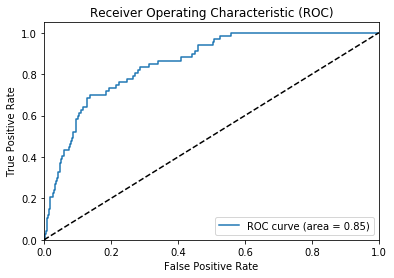

In [65]:
# Roc curve
predroc = model.predict(x_valid)
predroc = predroc[:,1] # Only positive cases
y_compareroc=np.argmax(y_valid,axis=1)

plot_roc(predroc,y_compareroc)

In [35]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 50)                550       
_________________________________________________________________
dense_26 (Dense)             (None, 25)                1275      
_________________________________________________________________
dense_27 (Dense)             (None, 10)                260       
_________________________________________________________________
dense_28 (Dense)             (None, 2)                 22        
Total params: 2,107
Trainable params: 2,107
Non-trainable params: 0
_________________________________________________________________


In [64]:
pred_valid_round=model.predict_classes(x_valid)
y_pred_valid=np.argmax(y_valid,axis=1)
print(y_pred_valid)

print(y_valid[0:25])
print(pred_validLL[0:25])
# Compute confusion matrix
cm = confusion_matrix(y_valid[:,1], pred_validLL[:,1]) 

#np.set_printoptions(precision=2)

[0 0 0 ... 0 0 0]
[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]
[0 0 0 ... 0 0 0]
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]
[[9.9986160e-01 1.3834771e-04]
 [9.6543360e-01 3.4566425e-02]
 [9.9980098e-01 1.9903637e-04]
 [9.9682546e-01 3.1745792e-03]
 [9.9992132e-01 7.8728801e-05]
 [9.2519355e-01 7.4806452e-02]
 [9.6838522e-01 3.1614795e-02]
 [9.9888891e-01 1.1111351e-03]
 [9.9922562e-01 7.7443296e-04]
 [9.8341310e-01 1.6586941e-02]
 [9.8305559e-01 1.6944405e-02]
 [9.9970120e-01 2.9880361e-04]
 [9.9366778e-01 6.3321823e-03]
 [9.7767776e-01 2.2322215e-02]
 [9.9993134e-01 6.8637280e-05]
 [9.9996173e-01 3.8293369e-05]
 [9.9948561e-01 5.1440176e-04]
 [9.9950528e-01 4.9469492e-04]
 [9.2238647e-01 7.7613547e-02]
 [9.9967980e-01 3.2020363e-04]
 [9.8614359e-01 1.3856335e-02]
 [8.6778927e-01 1.3221079e-

ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [55]:
y_valid[:,1]

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [50]:
#https://www.youtube.com/watch?v=km7pxKy4UHU
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



Confusion matrix, without normalization
[[4273    0]
 [  67    0]]
Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


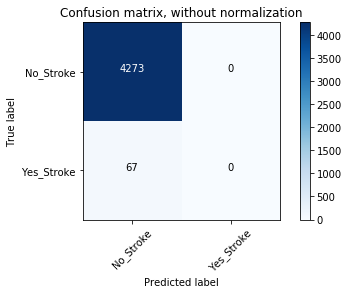

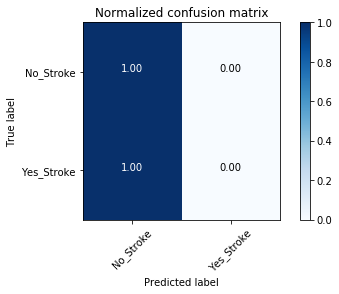

In [57]:
# Plot non-normalized confusion matrix
class_names = ['No_Stroke', 'Yes_Stroke']

plt.figure()
plot_confusion_matrix(cm, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [ ]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()
X = df_tr.drop('stroke', 1)
y = df_tr.stroke
print(y.head(5))

In [97]:
for i in df_tr_new['avg_glucose_level']:
    for j in key_count:
        if j == j:
            df_tr_new[i] = [x for x in val_count if x==1 ]

print (df_tr_new['avg_glucose_level'].head(20))
    

KeyboardInterrupt: 

In [81]:
            df_tr_new[i] = [x for x in val_count if x==1 ]
            df_tr_new['avg_glucose_level'] = ['2' for x in val_count if 2>= val >1]
            df_tr_new['avg_glucose_level'] = ['3' for x in val_count if 3>=val >2]
            df_tr_new['avg_glucose_level'] = ['4' for x in val_count if 4>= val >3]
            df_tr_new['avg_glucose_level'] = ['5' for x in val_count if 5>=val >4]
            df_tr_new['avg_glucose_level'] = ['6' for x in val_count if 6>= val >5]
    
            df_tr_new['avg_glucose_level'] = ['7' for x in val_count if 7>=val >6]
            df_tr_new['avg_glucose_level'] = ['8' for x in val_count if 8>= val >7]
            df_tr_new['avg_glucose_level'] = ['9' for x in val_count if 9>=val >8]
            df_tr_new['avg_glucose_level'] = ['10' for x in val_count if 10>= val >9]
            df_tr_new['avg_glucose_level'] = ['11' for x in val_count if 11>=val >10]
            df_tr_new['avg_glucose_level'] = ['12' for x in val_count if 12>= val >11]
            df_tr_new['avg_glucose_level'] = ['13' for x in val_count if 13>=val >12]
            df_tr_new['avg_glucose_level'] = ['14' for x in val_count if 14>= val >13]
            df_tr_new['avg_glucose_level'] = ['15' for x in val_count if 15>=val >14]



SyntaxError: invalid syntax (<ipython-input-81-b4020286157d>, line 1)

In [ ]:
import sklearn.feature_selection


X,y = tensor_flow_xy(df_tr, target)
select_tr = sklearn.feature_selection.SlectKBest(k=20)

x_train, x_valid, y_train, y_valid = train_test_split(X,y)